In [2]:
import matplotlib.pyplot as plt
from nltk.tree import Tree
import numpy as np
import re
import seaborn as sns
from transformers import AutoModel, AutoTokenizer
import torch

/Users/Emma/Desktop/capstone/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dir = "ch_copy/00/"
doc_id = '0037'

#function to get plain sentence, constituency parse and coreference-id-labeled tokens 
def get_sentence_profiles(doc_id):
    profiles = {}
    filename = "ch_" + doc_id + ".onf"
    fp = dir + filename
    with open(fp, "r") as f:
        lines = f.readlines()
    #enumerated = enumerate(lines) -- don't do this
    plain_sent_idxs = [i for i, txt in enumerate(lines) if txt == ("Plain sentence:\n")]
    treebanked_idxs = [i for i, txt in enumerate(lines) if txt.find("Treebanked sentence:\n") > -1]
    tree_idxs = [i for i, txt in enumerate(lines) if txt == ("Tree:\n")]
    leaves_idxs = [i for i, txt in enumerate(lines) if txt == ("Leaves:\n")]

    n_sents = len(plain_sent_idxs)

    for i in range(n_sents):
        profile = doc_id + "_" + str(i)
        profiles[profile] = {}
        profiles[profile]["plain"] = lines[(plain_sent_idxs[i] + 2):treebanked_idxs[i]][0].strip()
        profiles[profile]["plain"] = profiles[profile]["plain"].replace("--", "")
        raw_tree = lines[(tree_idxs[i]+2):leaves_idxs[i]]
        profiles[profile]["tree"] = process_tree(raw_tree)

        if i < n_sents - 1:
            profiles[profile]["leaves"] = lines[(leaves_idxs[i]+2):(plain_sent_idxs[i+1]-3)]
        else:
            profiles[profile]["leaves"] = lines[(leaves_idxs[i]+2):-3]

        profiles[profile]["leaves"] = process_leaves(profiles[profile]["leaves"])

        i += 1
    return profiles

def process_leaves(leafnotes):
    leaves_dict = {}
    i = 0
    for line in leafnotes:
        line = line.strip()
        if len(line) > 0:
            line = line.split()
            if line[0].isdigit():
                if line[1] != "--":
                    leaves_dict[i] = {"token":"", "info": []}
                    leaves_dict[i]["token"] = line[1]
                    i += 1
            elif i-1 in leaves_dict:
                leaves_dict[i-1]["info"].append(line)
       
    return leaves_dict

def process_tree(raw_tree):
    tree = ""
    for line in raw_tree:
        tree += line.strip()
    return tree

def get_doc_profile(doc_id):
    profile = {}
    sentence_profiles = get_sentence_profiles(doc_id)
    profile["plain"] = ""
    for id in sentence_profiles:
        profile["plain"] += sentence_profiles[id]["plain"]
    profile["tree"] = [sentence_profiles[profile]["tree"] for profile in sentence_profiles]
    profile["leaves"] = sentence_profiles[doc_id + "_0"]["leaves"]
    sentence_profiles_tail = dict(list(sentence_profiles.items())[1:])
    i = list(profile["leaves"].keys())[-1]
    for id in sentence_profiles_tail:
        for leaf in sentence_profiles[id]['leaves']:
            i += 1
            profile["leaves"][i] = sentence_profiles_tail[id]['leaves'][leaf]
    return profile


In [4]:
s_profiles = get_sentence_profiles(doc_id)
doc_profile = get_doc_profile(doc_id)
sample = s_profiles['0037_0']#['plain']

In [5]:
#tokenization

##word-level
def get_words(sentence_profile):
    leaves = sentence_profile["leaves"]
    #words = [(idx, leaves[i]["token"]) for idx, i in enumerate(leaves)]
    words = [leaves[i]["token"] for i in leaves]
    return words

##character-level
def get_characters(sentence_profile):
    #characters = [(idx, ch) for idx, ch in enumerate(sentence_profile["plain"])]
    characters = [ch for ch in sentence_profile["plain"]]
    return characters

In [6]:
#set model and tokenizer
model_name = "hfl/chinese-bert-wwm" #"ckiplab/gpt2-base-chinese" #"bert-base-chinese"
from transformers import AutoTokenizer, AutoModelForCausalLM
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_attentions=True)

In [7]:
heads = 0
layers = 0

#returns attention weights for specified head
def attention_map(model, text, heads, layers):
    inputs = tokenizer(text, return_tensors="pt")
    outputs = model(**inputs)
    print(torch.stack(outputs.attentions).shape)
    attention_matrix = torch.stack(outputs.attentions)[layers, :, heads, :, :].squeeze(0).detach().numpy()
    print(attention_matrix.shape)
    # = attention[layers.unsqueeze(0), :, heads, :, :]
    #print(selection.shape)
    #aggregate = attention.sum(dim = 0).detach().numpy()
    #print(aggregate.shape)
    
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    punct_idxs = [idx for idx, token in enumerate(tokens) if token in [",", "[CLS]", "[SEP]"]]
    tokens = [token for i, token in enumerate(tokens) if i not in punct_idxs]
    attention_matrix = np.delete(attention_matrix, punct_idxs, axis = 1)
    attention_matrix = np.delete(attention_matrix, punct_idxs, axis = 0)
    
    return attention_matrix #return aggregate.detach().numpy()
    #tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

In [8]:
#create CT instance and look for layers adhering to Cf rankings, try several aggregates of intermediate layers

#Hypothesis 1：linear order (looking for first-mention effect)
def mention_sequence(string):
    tree = Tree.fromstring(string)
    lleaves = tree.pos()
    return [(i, leaf[0]) for i, leaf in enumerate(lleaves) if "N" in leaf[1] and "*-" not in leaf[0]]

def mention_set(string):
    return set(mention_sequence(string)) #ensure that order is preserved

#Hypothesis 2: grammatical role (ranking by grammatical role)

#Hypothesis 3: 

In [9]:
print((sample["tree"]))
print(mention_sequence(sample["tree"]))

(TOP (UCP (IP (NP-SBJ (-NONE- *pro*))(VP (ADVP (AD 就))(VP (VV 觉)(CP-OBJ (IP (NP-SBJ (-NONE- *pro*))(VP (ADVP (AD 挺))(ADVP (AD 不))(VP (VV 舒服))))(SP 的))(PU ,))))(CP (IP (ADVP (AD 本来))(ADVP (AD 就是))(NP-SBJ (NN 信心))(VP (ADVP (AD 挺))(VP (VA 足))))(SP 的))(PU .)))
[(0, '*pro*'), (3, '*pro*'), (11, '信心')]


In [38]:
tree = Tree.fromstring(sample["tree"])
#print(sample["leaves"])
null_sbj_idxs = [i for i in sample["leaves"] if sample["leaves"][i]["token"] == "*pro*" and sample["leaves"][i]["info"]]
#rint(null_sbj_idxs)
nsubj_tree_positions = [tree.leaf_treeposition(idx) for idx in null_sbj_idxs]
#print(nsubj_tree_positions)
nsubj1_position = nsubj_tree_positions[0]
t_positions = tree.treepositions(order='preorder')
#print(tree[nsubj1_position])
#print(tree[t_positions[t_positions.index(nsubj1_position) -1]])
#print(tree[t_positions[t_positions.index(nsubj1_position) -2]])
#print(tree[t_positions[t_positions.index(nsubj1_position) -3]])

def get_main_verb(tree, nsubj_idx):
    t_positions = tree.treepositions(order = 'preorder')
    leaf_positions = [tree.leaf_treeposition(idx) for idx in range(len(tree.leaves()))]
    nsubj_leaf_position = tree.leaf_treeposition(nsubj_idx)
    IP_idx = t_positions.index(nsubj_leaf_position) - 3
    IP_pos = t_positions[IP_idx]
    IP_tree = tree[IP_pos]
    IPt_positions = IP_tree.treepositions(order='preorder')
    mv_idx = None
    for i in range(len(IPt_positions)):
        position = IPt_positions[i]
        if type(IP_tree[position]) == str and IP_tree[IPt_positions[i-1]].label() == 'VV':
            print(IP_tree[IPt_positions[i-1]])
            mv_idx = leaf_positions.index(t_positions[IP_idx + i])
            print(mv_idx)
            return mv_idx
    return None

get_main_verb(tree, 3)

(VV 舒服)
6


6

In [22]:
tree.pretty_print()

                                           TOP                                          
                                            |                                            
                                           UCP                                          
              ______________________________|_________________________________________   
             IP                                                      |                | 
   __________|__________                                             |                |  
  |                     VP                                           |                | 
  |      _______________|_________                                   |                |  
  |     |                         VP                                 |                | 
  |     |     ____________________|_____________                     |                |  
  |     |    |                  CP-OBJ          |                    CP               | 
  |     |    |  

In [ ]:
def test_hyp_1(profile, is_bidirectional = True):
    tree = Tree.fromstring(profile["tree"])
    leafnotes = profile["leaves"]
    null_sbj_idxs = [i for i in leafnotes if leafnotes[i]["token"] == "*pro*" and not leafnotes["info"].isempty()]
    nsubj_tree_position = [tree.leaf_treeposition(idx) for idx in null_sbj_idxs]

    #for map in attention_map:
    
hypotheses = {1: test_hyp_1}      

torch.Size([12, 1, 12, 20, 20])
(20, 20)


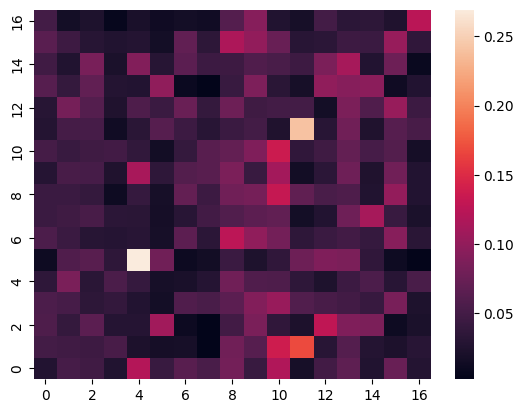

In [301]:
attention_matrix = attention_map(model, sample['plain'], heads, layers)
figure = sns.heatmap(attention_matrix, xticklabels=2, yticklabels=2)
figure.invert_yaxis()
plt.show()